Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [69]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [71]:
!ls '/content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration'

Test  Train


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [73]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
# data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [74]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2238
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [75]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [95]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2238 files belonging to 9 classes.
Using 1791 files for training.


In [77]:
## Write your validation dataset here
## Note use seed=123++odo


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [96]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [91]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df



,Class,No. of Image
0,basal cell carcinoma,376
1,actinic keratosis,114
2,dermatofibroma,94
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


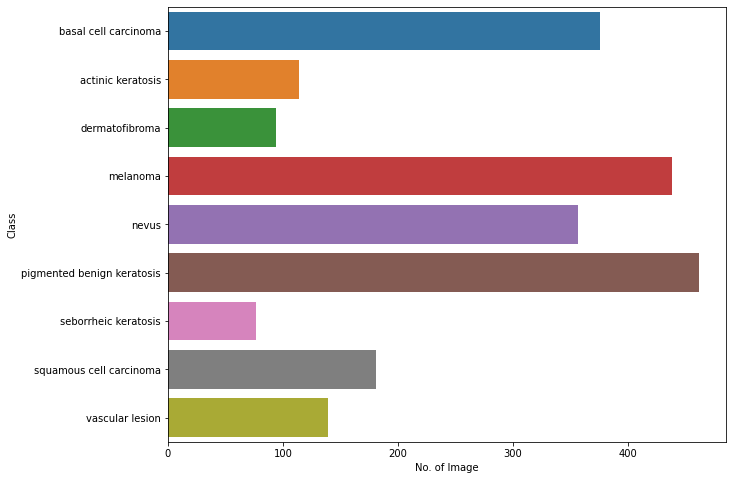

In [93]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

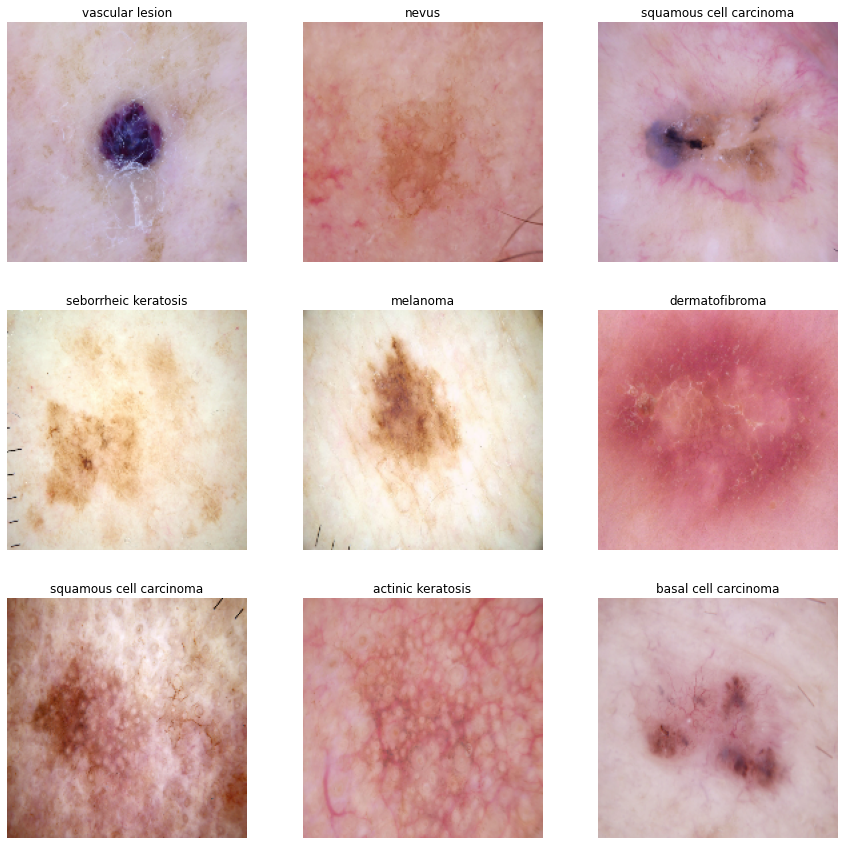

In [79]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize


sample_image = None
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

for images, labels in train_ds.take(1):  #Looping through images of position 1
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    if (i==1):
     sample_image = images[i].numpy().astype("uint8")
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [80]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [81]:
### Your code goes here
num_classes = 9  # To detect 9 classes present in the dataset
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [82]:
### Todo, choose an appropirate optimiser and loss function
# model.compile(optimizer='your_optimser',
#               loss=your_loss_function_goes_here,
#               metrics=['accuracy'])

model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [83]:
# View the summary of all layers

model.build(input_shape=(None,180,180,3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 118336)           

### Train the model

In [84]:
epochs = 20
history = model.fit(  train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 176s 2s/step - loss: 2.1193 - accuracy: 0.3255 - val_loss: 2.5252 - val_accuracy: 0.1739
Epoch 2/20
56/56 [==============================] - 103s 2s/step - loss: 1.5106 - accuracy: 0.4913 - val_loss: 2.5891 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 110s 2s/step - loss: 1.3416 - accuracy: 0.5438 - val_loss: 2.3890 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 104s 2s/step - loss: 1.2793 - accuracy: 0.5522 - val_loss: 2.7652 - val_accuracy: 0.2174
Epoch 5/20
56/56 [==============================] - 112s 2s/step - loss: 1.1323 - accuracy: 0.5980 - val_loss: 2.6179 - val_accuracy: 0.2174
Epoch 6/20
56/56 [==============================] - 102s 2s/step - loss: 0.9840 - accuracy: 0.6594 - val_loss: 2.7307 - val_accuracy: 0.2174
Epoch 7/20
56/56 [==============================] - 114s 2s/step - loss: 0.8780 - accuracy: 0.6935 - val_loss: 3.4045 - val_accuracy: 0.2174
Epoch 8/20
56

### Visualizing training results

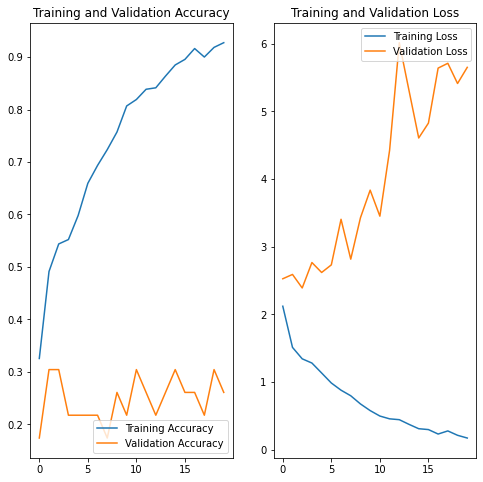

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
### "The model seems to be not performing positively and shows signs of a Under Fit Model"

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here


# augumentation strategy i will select here is Horizontal 
# data_augmentation = keras.Sequential(
#   [
#     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),      
#   ]
# )


data_augmentation = keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width,3)),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='nearest'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


type(data_augmentation)

keras.engine.sequential.Sequential

<Figure size 720x720 with 0 Axes>

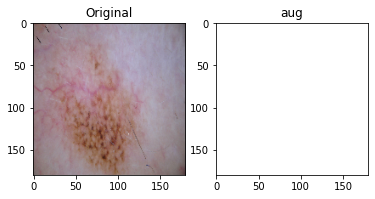

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

image = tf.expand_dims(sample_image, 0)
augmented_image = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3))(image)


type(augmented_image)
plt.figure(figsize=(10, 10))
_, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image)
ax[0].set_title("Original")
ax[1].imshow(augmented_image[0])
ax[1].set_title("aug");



### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.Sequential([data_augmentation,
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, activation='relu'),
layers.MaxPooling2D(2),
layers.Dropout(0.25),
layers.Conv2D(64, 3, activation='relu'),
layers.MaxPooling2D(2),
layers.Dropout(0.25),
layers.Conv2D(128, 3, activation='relu'),
layers.MaxPooling2D(2),
layers.Dropout(0.25),
layers.Flatten(),
layers.Dense(512, activation='relu'),
layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
# history = ## your training code

epochs = 20
history = model.fit(train_ds,batch_size=batch_size,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 3s 35ms/step - loss: 2.1899 - accuracy: 0.1904 - val_loss: 2.3269 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 2.0353 - accuracy: 0.2099 - val_loss: 2.2553 - val_accuracy: 0.0435
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 2.0263 - accuracy: 0.2071 - val_loss: 2.2844 - val_accuracy: 0.0435
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.9285 - accuracy: 0.2730 - val_loss: 2.1200 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7004 - accuracy: 0.3948 - val_loss: 2.3044 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5953 - accuracy: 0.4350 - val_loss: 2.4588 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5499 - accuracy: 0.4645 - val_loss: 2.2626 - val_accuracy: 0.3043
Epoch 8/20
56

### Visualizing the results

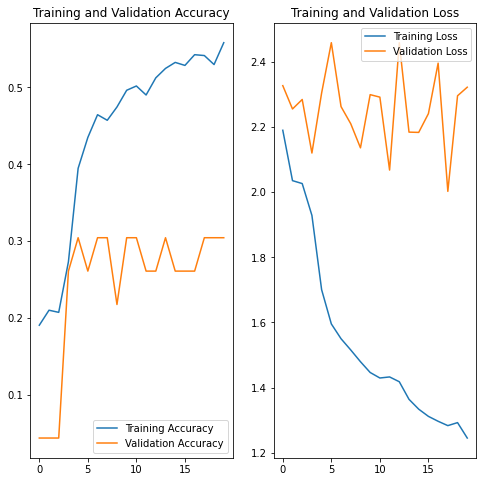

In [ ]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

#### We see a remarkable improvement in Validation accuracy and lessen in loss

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.


from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns=['Path','Label'])
dataframe_dict

original_df['Label'].value_counts()


pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 94
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
path_to_training_dataset = "/content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F08F59B02D0>: 100%|██████████| 500/500 [00:18<00:00, 27.58 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F08F5DCFF50>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


Initialised with 94 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F08F5CE7E90>: 100%|██████████| 500/500 [00:21<00:00, 22.85 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F08F5976550>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F08F594B990>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F08F5F46D10>: 100%|██████████| 500/500 [00:18<00:00, 26.55 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F08F596AD10>: 100%|██████████| 500/500 [00:41<00:00, 11.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F08F5C55190>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F08F5E61A10>: 100%|██████████| 500/500 [00:18<00:00, 27.41 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                594
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
# data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = "/content/gdrive/My Drive/Colab Notebooks/CNNAssignmentUpgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to.
  image_size=(img_height,img_width),
  batch_size=batch_size)


Found 6738 files belonging to 9 classes.
Using 5391 files for training.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6738 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model = tf.keras.Sequential([data_augmentation,
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, activation='relu'),
layers.MaxPooling2D(2),
layers.Dropout(0.25),
layers.Conv2D(64, 3, activation='relu'),
layers.MaxPooling2D(2),
layers.Dropout(0.25),
layers.Conv2D(128, 3, activation='relu'),
layers.MaxPooling2D(2),
layers.Dropout(0.25),
layers.Flatten(),
layers.Dense(512, activation='relu'),
layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [90]:
## your code goes here

model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
# epochs = 30
# ## Your code goes here, use 50 epochs.
# history = # your model fit code

epochs = 50
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)


Epoch 1/50
169/169 [==============================] - 38s 217ms/step - loss: 2.2442 - accuracy: 0.1627 - val_loss: 2.0610 - val_accuracy: 0.1967
Epoch 2/50
169/169 [==============================] - 33s 189ms/step - loss: 1.7892 - accuracy: 0.3072 - val_loss: 1.7180 - val_accuracy: 0.3460
Epoch 3/50
169/169 [==============================] - 33s 191ms/step - loss: 1.5990 - accuracy: 0.3901 - val_loss: 1.5546 - val_accuracy: 0.4291
Epoch 4/50
169/169 [==============================] - 35s 200ms/step - loss: 1.5092 - accuracy: 0.4200 - val_loss: 1.4749 - val_accuracy: 0.4922
Epoch 5/50
169/169 [==============================] - 33s 190ms/step - loss: 1.4123 - accuracy: 0.4611 - val_loss: 1.4593 - val_accuracy: 0.4454
Epoch 6/50
169/169 [==============================] - 33s 189ms/step - loss: 1.3425 - accuracy: 0.4860 - val_loss: 1.3272 - val_accuracy: 0.4974
Epoch 7/50
169/169 [==============================] - 33s 190ms/step - loss: 1.2886 - accuracy: 0.4895 - val_loss: 1.2652 - val_ac

#### **Todo:**  Visualize the model results

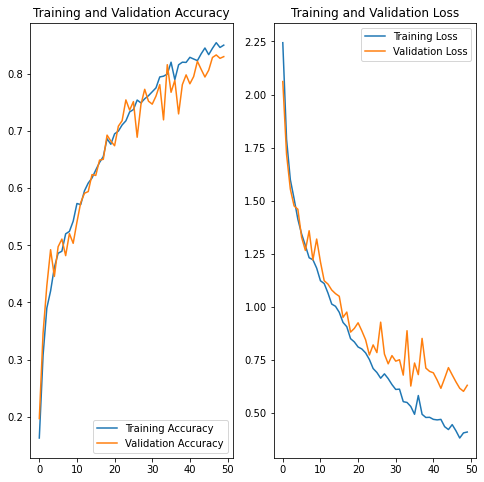

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

